In [281]:
# Thư viện xử lý dữ liệu dạng bảng
import pandas as pd  

# Thư viện vẽ đồ thị dựa trên matplotlib
import seaborn as sns  

# Thư viện thống kê
import scipy.stats as stats  

# Import thư viện statsmodels để sử dụng module tương tác với mô hình hồi quy tuyến tính.
import statsmodels.api as sm

# Thư viện vẽ đồ thị
import matplotlib.pyplot as plt 

In [282]:
# Thư viện itertools hỗ trợ tạo các tổ hợp
from itertools import combinations

# Thư viện statsmodels.formula.api hỗ trợ xây dựng mô hình tuyến tính
from statsmodels.formula.api import ols

# 1.&nbsp;Đọc dữ liệu và xem thông tin

In [283]:
# Đọc dữ liệu từ file csv
df = pd.read_csv('../data/CarPricePrediction_Clean.csv')

In [284]:
# Liệt kê tên của các cột có trong bộ dữ liệu
df.columns

Index(['Màu sắc', 'Phân loại người bán', 'Tỉnh', 'Hãng', 'Dòng xe',
       'Năm sản xuất', 'Số Km đã đi', 'Tình trạng', 'Hộp số', 'Nhiên liệu',
       'Kiểu dáng', 'Số chỗ', 'Xuất xứ', 'Đối tác', 'Giá'],
      dtype='object')

In [285]:
# Hiển thị 5 dòng đầu tiên của bộ dữ liệu
df.head()

,Màu sắc,Phân loại người bán,Tỉnh,Hãng,Dòng xe,Năm sản xuất,Số Km đã đi,Tình trạng,Hộp số,Nhiên liệu,Kiểu dáng,Số chỗ,Xuất xứ,Đối tác,Giá
0,đen,Bán chuyên,Hà Nội,Mitsubishi,Xpander,2022,50000,Đã sử dụng,Tự động,Xăng,Minivan (MPV),7,Đang cập nhật,No,559000000
1,nâu,Cá nhân,Tp Hồ Chí Minh,Nissan,Sunny,2019,52000,Đã sử dụng,Tự động,Xăng,Sedan,5,Hàn Quốc,No,335000000
2,đen,Cá nhân,Tp Hồ Chí Minh,Ford,Escape,2003,50000,Đã sử dụng,Tự động,Xăng,SUV / Cross over,5,Việt Nam,No,106000000
3,đen,Cá nhân,Tp Hồ Chí Minh,Hyundai,Accent,2021,42,Đã sử dụng,Tự động,Xăng,Sedan,4,Hàn Quốc,No,450000000
4,đỏ,Bán chuyên,Hà Nội,Ford,Ranger,2022,51000,Đã sử dụng,Tự động,Dầu,SUV / Cross over,5,Việt Nam,No,534000000


In [286]:
# Hiển thị thông tin bộ dữ liệu hiện tại
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Màu sắc              2685 non-null   object
 1   Phân loại người bán  2685 non-null   object
 2   Tỉnh                 2685 non-null   object
 3   Hãng                 2685 non-null   object
 4   Dòng xe              2685 non-null   object
 5   Năm sản xuất         2685 non-null   int64 
 6   Số Km đã đi          2685 non-null   int64 
 7   Tình trạng           2685 non-null   object
 8   Hộp số               2685 non-null   object
 9   Nhiên liệu           2685 non-null   object
 10  Kiểu dáng            2685 non-null   object
 11  Số chỗ               2685 non-null   int64 
 12  Xuất xứ              2685 non-null   object
 13  Đối tác              2685 non-null   object
 14  Giá                  2685 non-null   int64 
dtypes: int64(4), object(11)
memory usage: 314.8+ KB


In [287]:
# Tiếp theo, ta sẽ phân loại ra cho chúng là các biến số và biến phân loại.
# Đồng thời, lưu lại tên của biến mục tiêu
target_col = 'Giá'
numeric_cols = [column for column in df.columns if df[column].dtype !=
                'object' and column != 'Giá']
categories_cols = [
    column for column in df.columns if column not in numeric_cols and column != 'Giá']

# 2.&nbsp;Phân tích biến mục tiêu

Chúng tôi đã tiến hành vẽ biểu đồ Histogram và biểu đồ Boxplot cho biến mục tiêu là `Giá` để xem về phân phối của các giá trị trong biến này. Qua 2 biểu đồ trên, chúng tôi rút ra được một số nhận xét như sau:
- **Biểu đồ Histogram:** Ta có thể thấy rõ rằng tần suất của các mức giá tập trung nhiều nhất ở góc bên trái của biểu đồ do các cột ở vị trí đó là cao nhất cũng như đường cong KDE có đỉnh cũng tập trung tại vị trí đó.
- **Biểu đồ Boxplot:** Tương tự với Histogram, các khoảng giá cũng tập trung nhiều ở góc bên trái biểu đồ do đây là giá của các xe cũ nên mức giá thấp sẽ chiếm nhiều hơn các mức giá cao. Khoảng giá chiếm tần suất cao nhất là từ 318 triệu đồng đến 679 triệu đồng. Giá xe phổ biến nhất trong bộ dữ liệu là 476 triệu đồng.

In [288]:
def get_iqr_range_for_column(df, column_name):
    """
    Xuất khoảng IQR (Interquartile Range) của một cột trong DataFrame.

    Parameters:
    - df: DataFrame, DataFrame chứa dữ liệu.
    - column_name: str, Tên của cột cần xuất khoảng IQR.

    Returns:
    - tuple, Bao gồm giá trị Q1 và Q3.
    """

    # Lấy dữ liệu từ cột
    data = df[column_name]

    # Tính Q1 và Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    return Q1, Q3


def plot_histogram_and_boxplot(data, variable):
    """
    Vẽ hai biểu đồ histogram và boxplot bên cạnh nhau cho biến số.

    Parameters:
    - data: DataFrame, dữ liệu chứa biến số.
    - variable: str, tên biến số trong DataFrame.

    Returns:
    None (Hiển thị biểu đồ).
    """

    plt.figure(figsize=(12, 5))

    # Biểu đồ Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[variable], bins=30, kde=True,
                 color='skyblue', edgecolor='black')
    plt.title(f'Histogram - {variable}')
    plt.xlabel(variable)
    plt.ylabel('Tần suất')

    # Biểu đồ Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[variable], color='salmon')
    plt.title(f'Boxplot - {variable}')
    plt.xlabel(variable)

    plt.tight_layout()
    plt.show()

Giá xe có tần suất xuất hiện cao nhất là: 476000000.0
Khoảng giá có tần suất xuất hiện cao nhất là (318000000.0, 679000000.0)


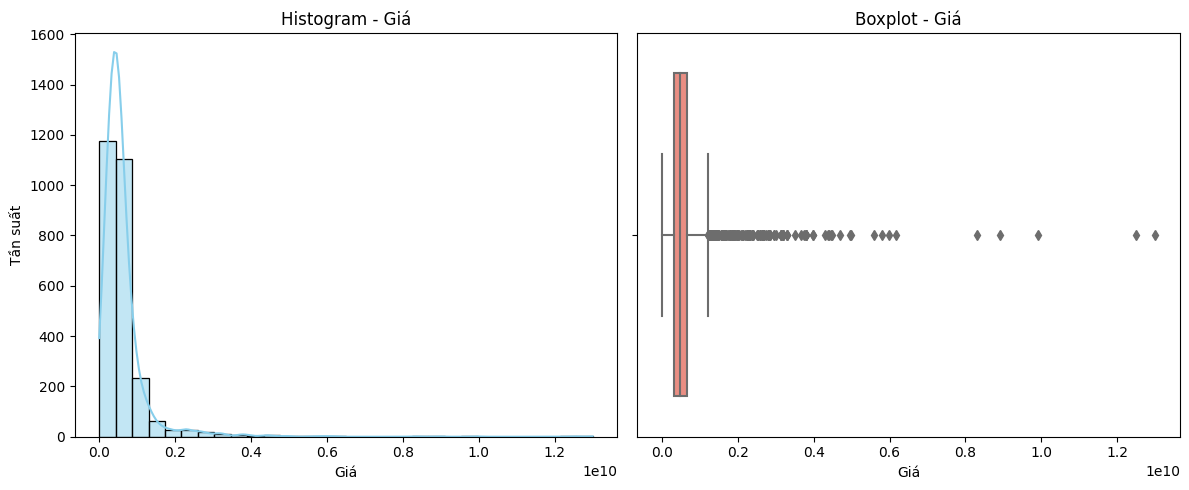

In [289]:
# Xem giá xuất hiện nhiều nhất (Q2) và khoảng phổ biến dựa vào IQR của "Giá"
Q2 = df[target_col].quantile(0.5)
IQR = get_iqr_range_for_column(df, target_col)
print(f"Giá xe có tần suất xuất hiện cao nhất là: {Q2}")
print(f"Khoảng giá có tần suất xuất hiện cao nhất là {IQR}")

# Vẽ biểu đồ histogram và boxplot cho biến "Giá"
plot_histogram_and_boxplot(df, target_col)

# 3.&nbsp;Phân tích biến số

## 3.1.&nbsp;Thống kê các số liệu cơ bản

In [290]:
# Tạo bảng thống kê tóm tắt về các biến số trong DataFrame bằng phương thức describe().
# Kết quả là một DataFrame với các chỉ số thống kê 
# như count, mean, std, min, 25%, 50%, 75%, và max.
# Chuyển vị DataFrame để hiển thị thông tin theo cột (biến số).
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Năm sản xuất,2685.0,2.016857e+03,5.559722e+00,1979.0,2014.0,2018.0,2021.0,2.023000e+03
Số Km đã đi,2685.0,5.339313e+04,3.221446e+04,4.0,28000.0,50000.0,80000.0,1.200000e+05
Số chỗ,2685.0,5.629050e+00,1.755610e+00,2.0,5.0,5.0,7.0,1.600000e+01
Giá,2685.0,6.198079e+08,7.191079e+08,5000000.0,318000000.0,476000000.0,679000000.0,1.300000e+10


## 3.2.&nbsp;Kiểm tra tính đối xứng

Nhận xét về tính đối xứng (với sai số 0.1) như sau:
- Các biến đối xứng: `Năm sản xuất` và `Số chỗ`
- Các biến không đối xứng: `Số Km đã đi` và `Giá`

In [291]:
def check_symmetry(column: pd.Series, tolerance_percent: float) -> bool:
    """
    Kiểm tra tính đối xứng của một cột thuộc tính với sai số cho trước.

    Parameters:
    - column: pd.Series, Cột thuộc tính cần kiểm tra.
    - tolerance_percent: float, Sai số cho phép (tính theo phần trăm).

    Returns:
    - bool, True nếu cột thuộc tính là đối xứng, False nếu không phải.
    """
    # Tính giá trị trung bình, trung vị và mode của cột thuộc tính.
    mean_value = column.mean()
    median_value = column.median()
    mode_values = column.mode()

    # Kiểm tra xem có một mode hay không, nếu có thì chỉ xét với mode[0].
    if len(mode_values) == 1:
        # Tính toán sai số theo phần trăm.
        mean_median_difference = abs(mean_value - median_value) / 100
        median_mode_difference = abs(median_value - mode_values[0]) / 100

        # Kiểm tra tính đối xứng với sai số cho trước.
        if mean_median_difference <= tolerance_percent and median_mode_difference <= tolerance_percent:
            return True

    # Nếu không có hoặc có nhiều hơn một mode, cột không đối xứng.
    return False


def create_symmetry_df(dataframe, numeric_columns, target_column=None, percent_threshold=0.1):
    """
    Tạo DataFrame chứa thông tin về đối xứng của các biến số kiểu số.

    Parameters:
    - dataframe: DataFrame, DataFrame chứa dữ liệu.
    - numeric_columns: list, Danh sách tên các biến kiểu số.
    - percent_threshold: float, Ngưỡng phần trăm sai số cho phép để coi là đối xứng.

    Returns:
    - DataFrame, DataFrame với tên biến số và cột đối xứng.
    """

    # Khởi tạo danh sách để lưu các DataFrame con.
    dfs = []

    # Duyệt qua từng biến số kiểu số trong danh sách.
    for column in numeric_columns:
        # Kiểm tra đối xứng và thêm vào danh sách.
        is_symmetric = check_symmetry(dataframe[column], percent_threshold)
        df = pd.DataFrame({'Tên biến': [column], 'Đối xứng?': [is_symmetric]})
        dfs.append(df)

    if target_column is not None:
        is_symmetric = check_symmetry(dataframe[target_column], percent_threshold)
        df = pd.DataFrame({'Tên biến': [target_column], 'Đối xứng?': [is_symmetric]})
        dfs.append(df)
        

    # Kết hợp tất cả các DataFrame con thành một DataFrame duy nhất.
    symmetry_df = pd.concat(dfs, ignore_index=True)

    return symmetry_df

In [292]:
# Tạo dataframe kiểm tra đối xứng cho các biến số với sai số là 0.1
create_symmetry_df(df, numeric_cols, target_col)

,Tên biến,Đối xứng?
0,Năm sản xuất,True
1,Số Km đã đi,False
2,Số chỗ,True
3,Giá,False


## 3.3.&nbsp;Biểu đồ tương quan

Dựa vào biểu đồ tương quan, ta thấy chỉ có giữa hai biến `Năm sản xuất` và `Số Km đã đi` là có tương quan nhưng là tương quan rất yếu (do nằm trong khoảng từ 0,3 đến 0,5). Do đó, ta có thể kết luận rằng giữa các biến số không có sự tương quan nào với nhau.

In [293]:
def correlation_plot(df, numeric_columns, target_column=None):
    """
    Tạo correlation plot cho các biến kiểu số trong DataFrame.

    Parameters:
    - df: DataFrame, DataFrame chứa dữ liệu.
    - numeric_columns: list, Danh sách các tên cột kiểu số.
    - target_column: str, Tên của cột giá muốn thêm vào.

    Returns:
    - None
    """
    # Chọn các cột kiểu số từ DataFrame.
    numeric_df = df.loc[:, numeric_columns].copy()

    # Kiểm tra xem có cột giá được chỉ định hay không.
    if target_column is not None and target_column in df.columns:
        # Nếu có, thêm cột giá vào DataFrame.
        numeric_df[target_column] = df[target_column]

    # Tính ma trận tương quan.
    correlation_matrix = numeric_df.corr()

    # Tạo correlation plot bằng seaborn.
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=.5)
    plt.title('Correlation Plot of Numeric Variables')
    plt.show()

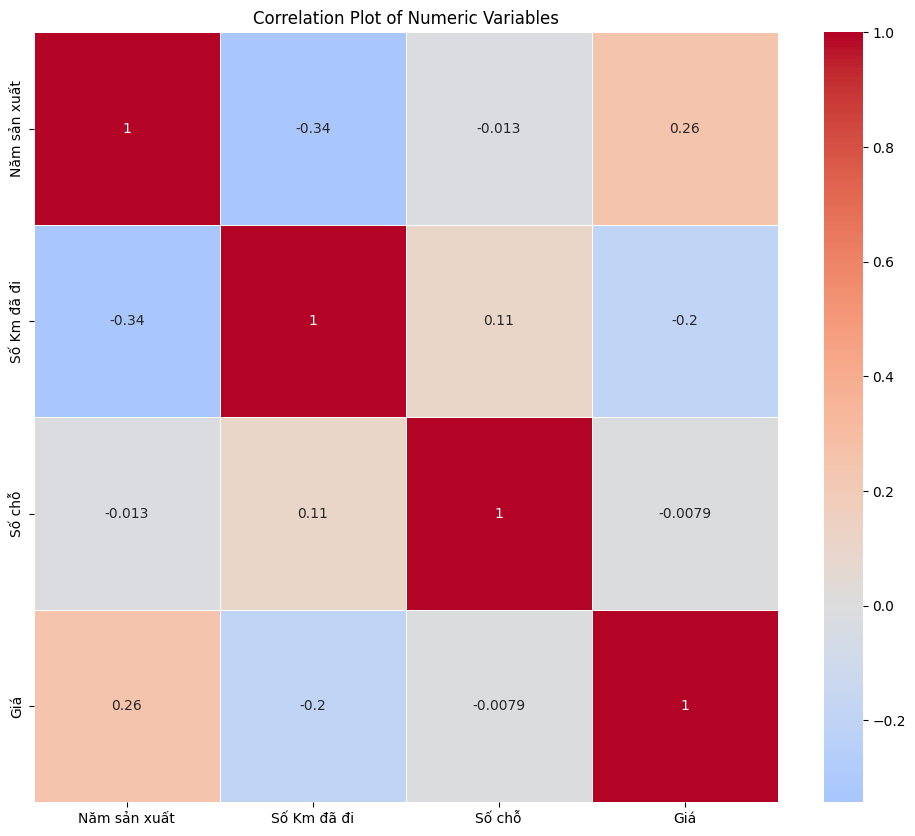

In [294]:
# Vẽ biểu đồ tương quan giữa các biến số
correlation_plot(df, numeric_cols, target_col)

## 3.4. Phân phối của các biến số

Chúng tôi đã tiến hành vẽ biểu đồ Boxplot và Histogram cho các biến số và rút ra được một số nhận xét như sau:
- **Năm sản xuất:** Những chiếc ô tô có số lượng nhiều nhất ở năm 2018 và nằm trong khoảng từ năm 2014 đến năm 2021.
- **Số Km đã đi:** Tập trung nhiều vào 50 nghìn km và nằm trong khoảng từ 28 nghìn km đến 80 nghìn km
- **Số chỗ:** Có số lượng nhiều nhất là 5 chỗ và nằm trong khoảng từ 5 đến 7 chỗ.

In [295]:
def boxplot_selected_variables(df, variable_list=None):
    """
    Vẽ boxplot cho các biến số được chọn trong DataFrame.

    Parameters:
    - df: DataFrame, DataFrame chứa dữ liệu.
    - variable_list: list, Danh sách tên các biến số cần vẽ boxplot. Nếu None, sẽ vẽ cho tất cả biến số kiểu số.

    Returns:
    - None (Hiển thị biểu đồ).
    """
    # Lấy danh sách các biến số kiểu số trong DataFrame.
    if variable_list is None:
        numeric_columns = df.select_dtypes(include='number').columns
    else:
        numeric_columns = variable_list

    # Thiết lập kích thước biểu đồ dựa trên số lượng biến số.
    plt.figure(figsize=(15, 6))

    # Vòng lặp để vẽ boxplot cho từng biến số.
    for i, col in enumerate(numeric_columns, 1):
        plt.subplot(1, len(numeric_columns), i)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot - {col}')

    # Chỉnh layout để tránh chồng lấn.
    plt.tight_layout()
    
    # Hiển thị biểu đồ.
    plt.show()


def histogram_selected_variables(data, variables):
    """
    Vẽ histogram cho danh sách các biến số.

    Parameters:
    - data: DataFrame, Dữ liệu chứa các biến số.
    - variables: list, Danh sách tên các biến số cần vẽ histogram.

    Returns:
    - None (Hiển thị biểu đồ).
    """

    # Lấy danh sách các biến số kiểu số trong DataFrame.
    if variables is None:
        variables = df.select_dtypes(include='number').columns

    # Thiết lập kích thước biểu đồ dựa trên số lượng biến số.
    plt.figure(figsize=(15, 6))
    
    for i, var in enumerate(variables, 1):
        plt.subplot(1, len(variables), i)
        sns.histplot(data[var], kde=True)
        plt.title(f'Histogram cho {var}')
        plt.xlabel(var)
        plt.ylabel('Tần suất')

    # Chỉnh layout để tránh chồng lấn.
    plt.tight_layout()
    
    # Hiển thị biểu đồ.
    plt.show()

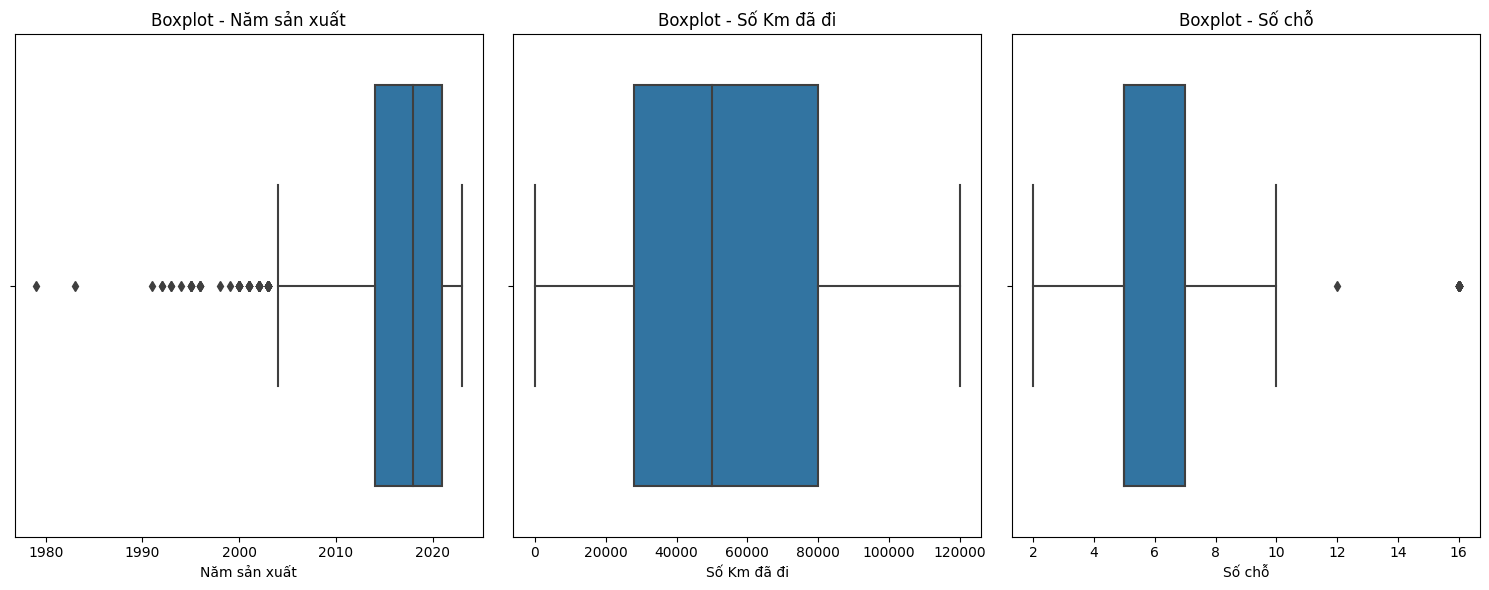

In [296]:
# Vẽ boxplot cho các biến số
boxplot_selected_variables(df, numeric_cols)

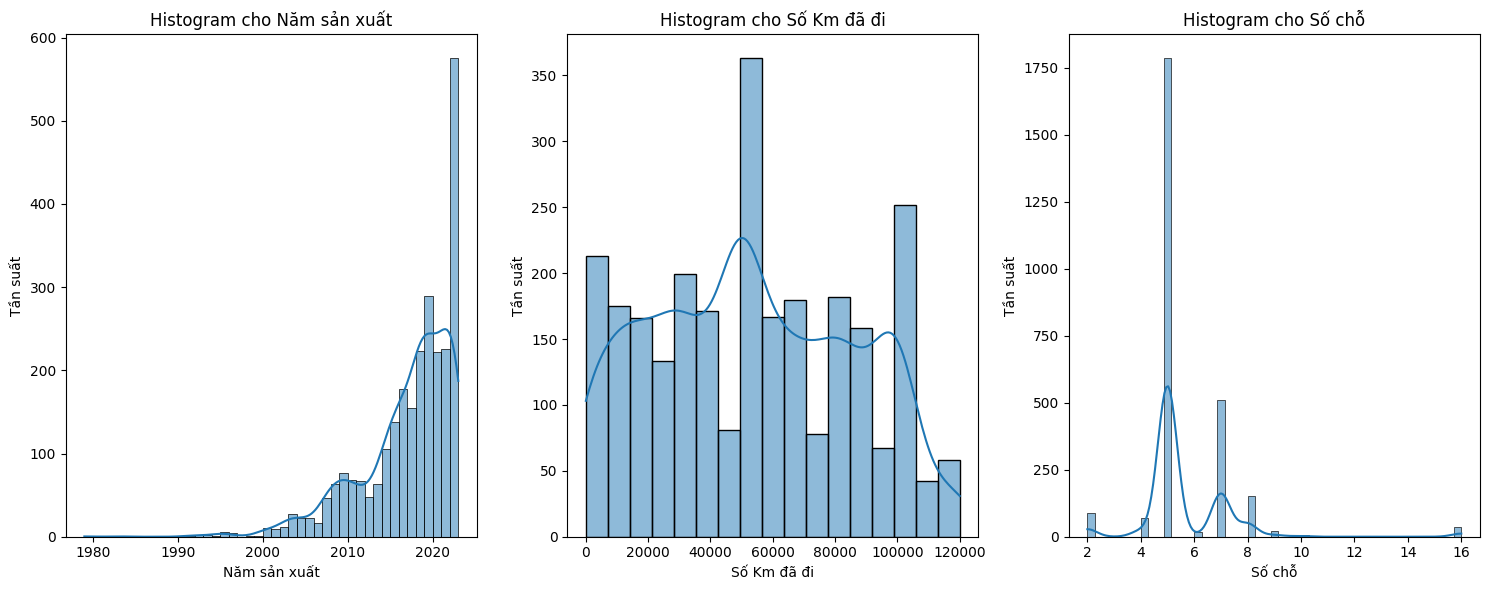

In [297]:
# Vẽ histogram và kde cho các biến số
histogram_selected_variables(df, numeric_cols)

## 3.5.&nbsp;Các biến số ảnh hưởng đến giá xe

Như thống kê bên dưới thì cả 3 biến `Năm sản xuất`, `Số Km đã đi` và `Số chỗ` đều không có ảnh hưởng đến giá xe.

In [298]:
def check_influence_level(series1: pd.Series, series2: pd.Series) -> int:
    """
    Kiểm tra mức độ ảnh hưởng giữa hai biến dựa trên hệ số tương quan và giá trị p.

    Tham số:
    - series1, series2: pd.Series, Hai Series cần kiểm tra.

    Trả về:
    - int, Mức độ ảnh hưởng: 0 (không ảnh hưởng), 1 (mạnh), 2 (trung bình), 3 (yếu).
    """
    # Tính hệ số tương quan và giá trị p giữa hai biến số.
    correlation_coefficient, p_value = stats.pearsonr(series1, series2)

    # Kiểm tra và đánh giá mức độ tương quan dựa trên hệ số và giá trị p.
    if p_value < 0.05:
        if 0.3 < abs(correlation_coefficient) <= 0.5:
            return 3  # Mức độ yếu
        elif 0.5 < abs(correlation_coefficient) <= 0.8:
            return 2  # Mức độ trung bình
        elif 0.8 < abs(correlation_coefficient) <= 1:
            return 1  # Mức độ mạnh

    return 0  # Không có ảnh hưởng


def find_influential_variables(df: pd.DataFrame, target_col: str, variable_list: list = None) -> pd.DataFrame:
    """
    Tìm tất cả các biến số ảnh hưởng đến biến mục tiêu và lưu vào DataFrame.

    Tham số:
    - df: pd.DataFrame, DataFrame chứa dữ liệu.
    - target_col: str, Tên cột biến mục tiêu.
    - variable_list: list, Danh sách tên các biến cần kiểm tra ảnh hưởng.

    Trả về:
    - pd.DataFrame, DataFrame chứa thông tin về mức độ ảnh hưởng của các biến.
    """
    # Kiểm tra nếu variable_list không được truyền vào, sử dụng tất cả các biến số kiểu số.
    if variable_list is None:
        variable_list = df.select_dtypes(include=['number']).columns.tolist()

    # Dictionary để lưu thông tin về mức độ ảnh hưởng của các biến.
    influence_dict = {'Tên biến': [], 'Mức độ ảnh hưởng': []}

    # Lặp qua từng biến số và kiểm tra ảnh hưởng.
    for col in variable_list:
        if col != target_col:
            influence_level = check_influence_level(df[col], df[target_col])
            influence_dict['Tên biến'].append(col)
            influence_dict['Mức độ ảnh hưởng'].append(influence_level)

    # Tạo DataFrame từ Dictionary.
    influence_df = pd.DataFrame(influence_dict)

    # Sắp xếp DataFrame theo mức độ ảnh hưởng tăng dần.
    influence_df = influence_df.sort_values(by='Mức độ ảnh hưởng')

    return influence_df

In [299]:
# Tìm tất cả các biến số có ảnh hưởng đến giá xe
find_influential_variables(df, target_col, numeric_cols)

,Tên biến,Mức độ ảnh hưởng
0,Năm sản xuất,0
1,Số Km đã đi,0
2,Số chỗ,0


# 4.&nbsp;Phân tích biến phân loại

## 4.1.&nbsp;Phân phối của các biến số

Theo các biểu đồ countplot mà chúng tôi vẽ được, chúng tôi có một số nhận xét như sau:
- `Màu sắc` nhiều nhất là đen, các màu còn lại chiếm số lượng không nhiều.
- `Phân loại người bán` nhiều nhất là Bán chuyên.
- `Tỉnh` bán xe nhiều nhất là Tp Hồ Chí Minh và Hà Nội.
- `Hãng` xuất hiện nhiều nhất là Toyota.
- `Dòng xe` nhiều nhất là Innova.
- `Tình trạng` chủ yếu là Đã sử dụng.
- `Hộp số` chủ yếu là Tự động.
- `Nhiên liệu` chủ yếu là Xăng.
- `Kiểu dáng` chủ yếu là Sedan.
- `Xuất xứ` chủ yếu là Việt Nam, nhiều xe vẫn còn Đang cập nhật.
- `Đối tác` thường là không có đối với các chủ xe.

In [300]:
def countplot_for_large_categorical_variable(data, column, figsize=(10, 6), ax=None):
    """
    Vẽ countplot cho biến phân loại có số lượng giá trị lớn.

    Parameters:
    - data: DataFrame, dữ liệu cần vẽ.
    - column: str, tên cột biến phân loại.
    - figsize: tuple, kích thước của biểu đồ.
    - ax: matplotlib.axes._subplots.AxesSubplot, trục để vẽ countplot.

    Returns:
    - None
    """

    # Vẽ countplot.
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()

    sns.countplot(data=data, x=column, order=data[column].value_counts().index, ax=ax)
    ax.set_title(f'Countplot - {column}')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel(f'Tần suất')


def countplot_for_all_categorical_variables(df: pd.DataFrame, categorical_columns_list: list = None, cols_per_row: int = 2):
    """
    Vẽ countplot cho tất cả các biến phân loại và lưu thành hình ảnh.

    Tham số:
    - df: pd.DataFrame, DataFrame chứa dữ liệu.
    - categorical_columns_list: list, Danh sách các biến phân loại cần vẽ countplot. Nếu None, sẽ sử dụng tất cả các biến phân loại.
    - cols_per_row: int, Số lượng cột biểu đồ trên mỗi hàng.

    Trả về:
    - None
    """

    # Lấy danh sách các cột có kiểu dữ liệu là 'object' (biến phân loại) nếu không có danh sách cụ thể được cung cấp.
    if categorical_columns_list is None:
        categorical_columns = df.select_dtypes(include=['object']).columns
    else:
        categorical_columns = categorical_columns_list

    # Tính số lượng hàng cần cho biểu đồ.
    num_rows = len(categorical_columns) // cols_per_row
    if len(categorical_columns) % cols_per_row != 0:
        num_rows += 1

    # Tạo lưới subplot với số lượng hàng và cột.
    fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 4 * num_rows))

    # Lặp qua tất cả các cột và vẽ countplot cho mỗi cột.
    for idx, column in enumerate(categorical_columns):
        row = idx // cols_per_row
        col = idx % cols_per_row

        # Gọi hàm countplot_for_large_categorical_variable để vẽ biểu đồ.
        countplot_for_large_categorical_variable(df, column, ax=axes[row, col])

    # Tinh chỉnh layout của subplot.
    plt.tight_layout()
    plt.show()

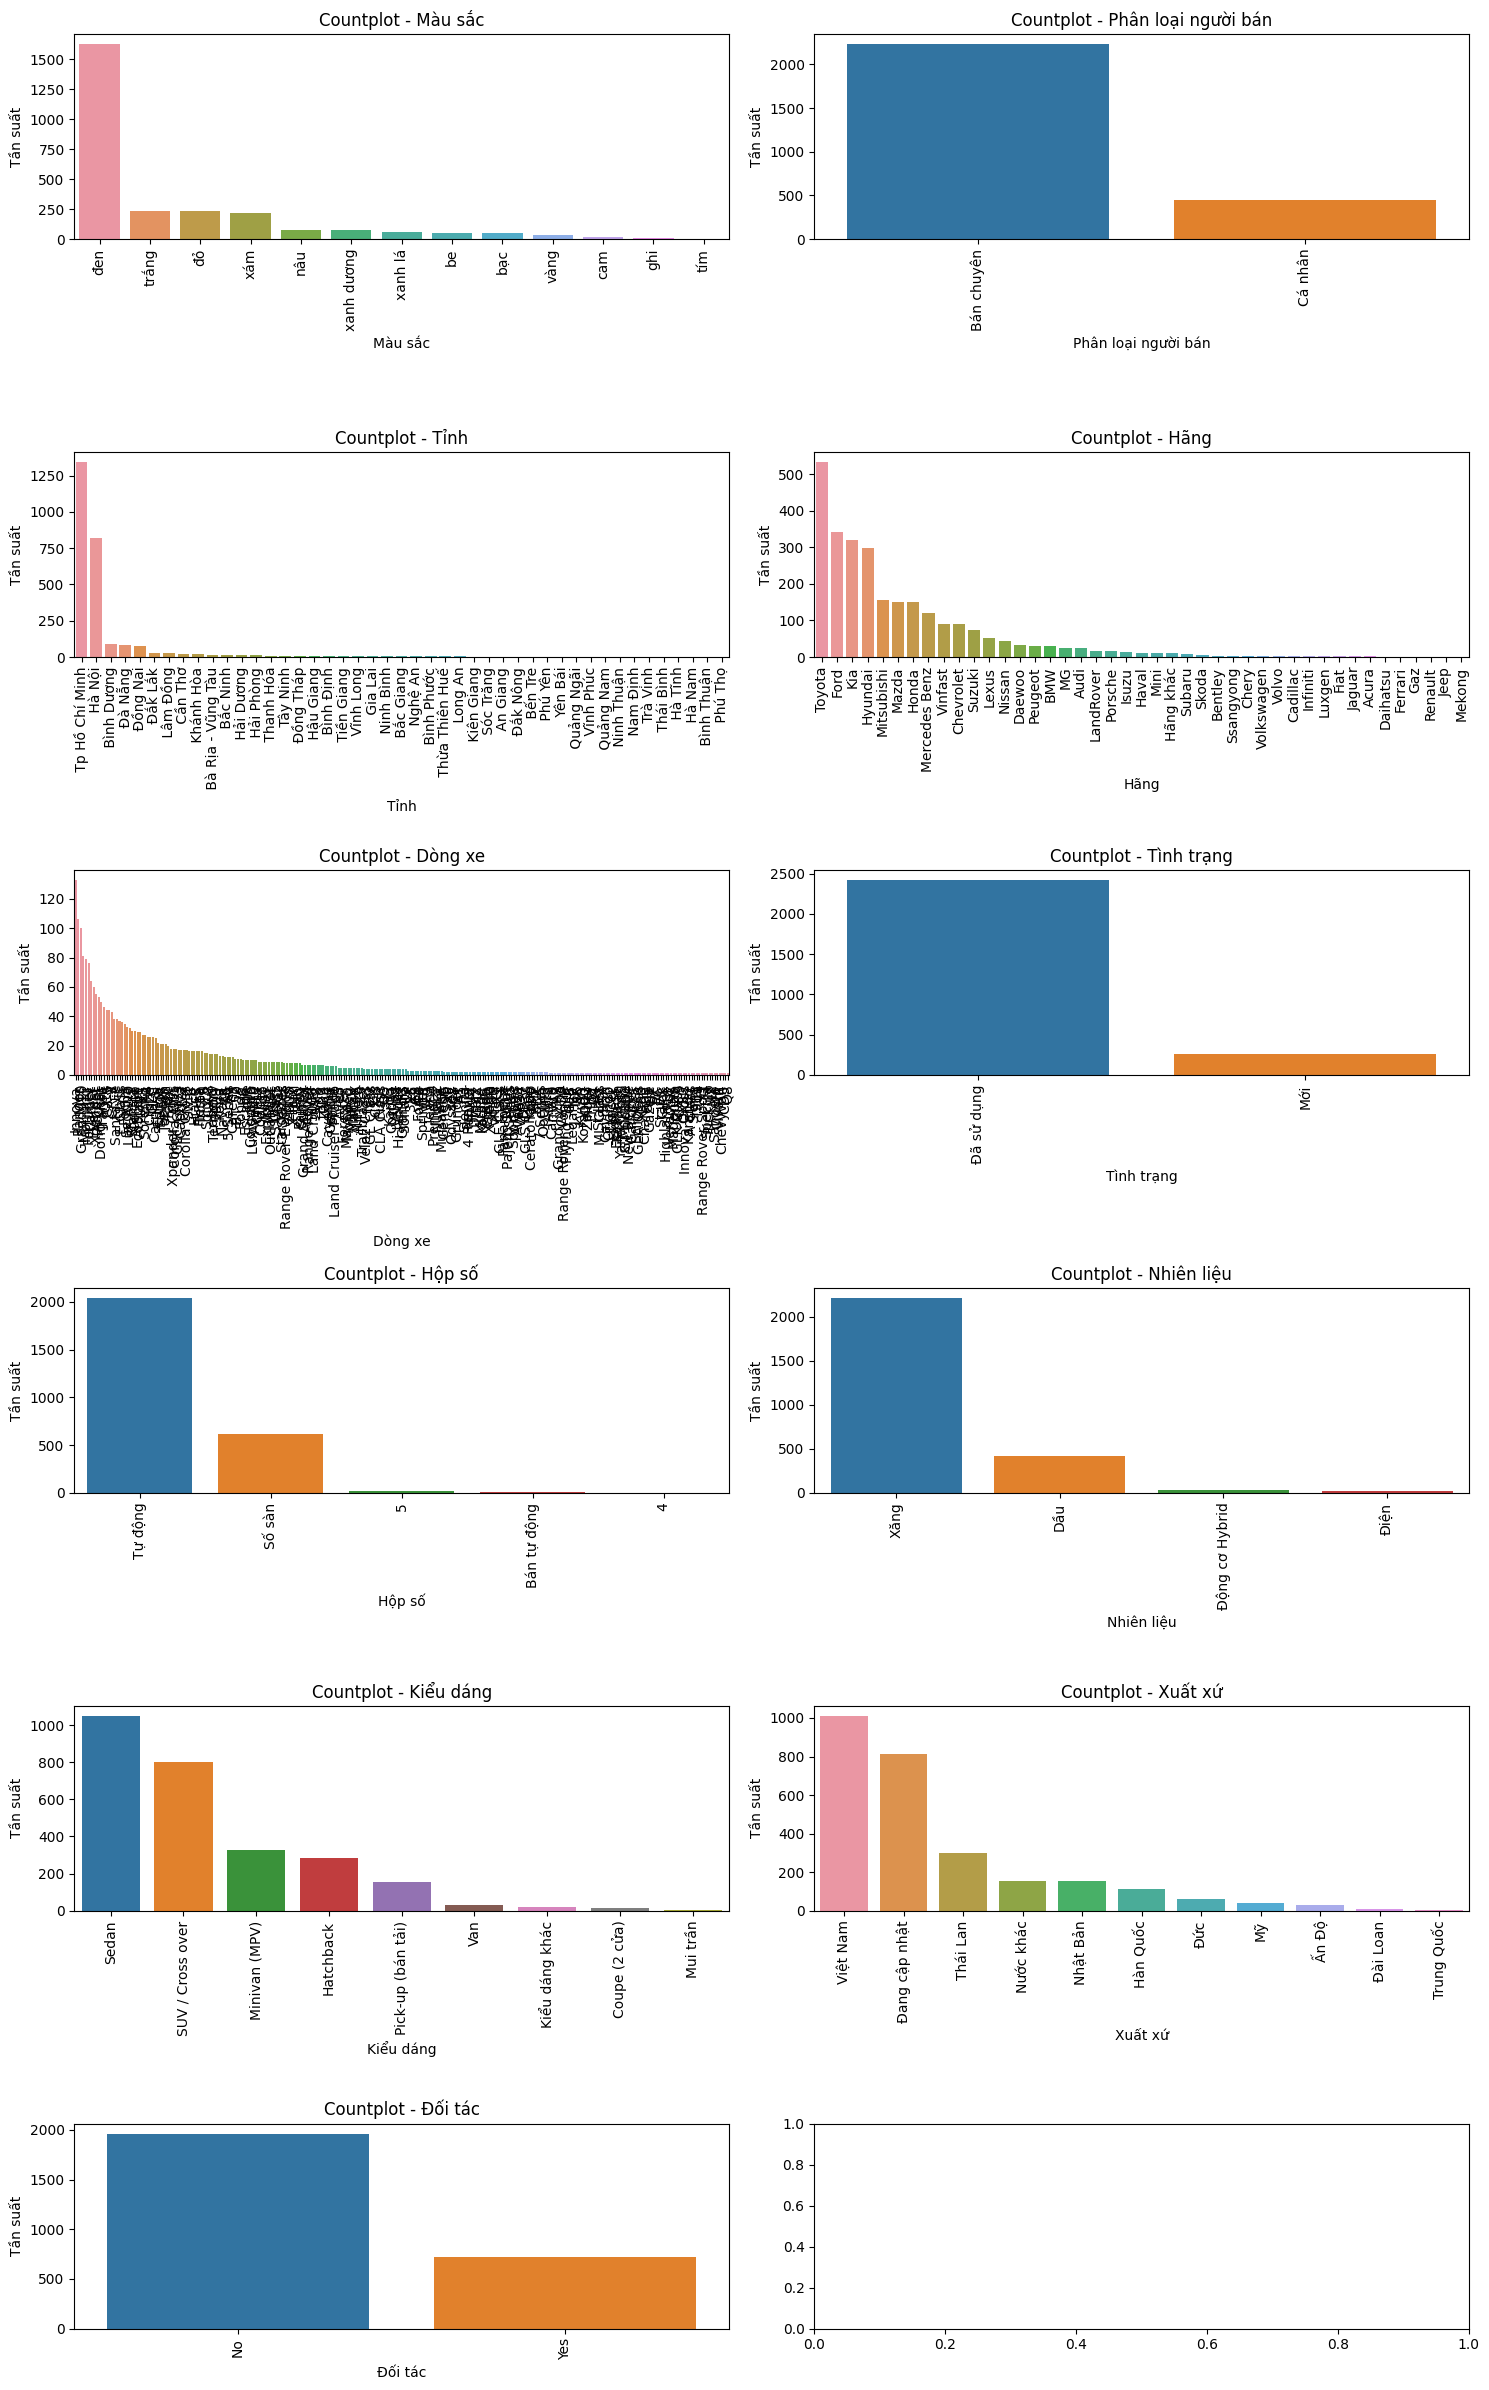

In [301]:
# Vẽ countplot cho tất cả các biến phân loại
countplot_for_all_categorical_variables(df, categories_cols)

In [302]:
# Do "Dòng xe" có quá nhiều giá trị nên chúng tôi sẽ dùng value_counts() để kiểm tra
df['Dòng xe'].value_counts()

Innova       133
Ranger       106
Vios         100
Grand i10     81
Morning       79
            ... 
Crown          1
Vivant         1
Chevyvan       1
CD5            1
Q8             1
Name: Dòng xe, Length: 254, dtype: int64

## 4.2.&nbsp;Tìm biến phân loại có khả năng ảnh hưởng đến giá xe ít nhất và nhiều nhất

- F-test càng lớn cho ta biết có sự khác biệt giữa số lượng giữa các biến phân loại, tức là có sự chênh lệch càng lớn giữa số lượng các nhãn có trong biến phân loại đó và p-value sẽ cho ta biết giá trị F-test có ý nghĩa hay không.
- Dựa vào F-test và p-value, ta có được các nhận xét sau đây:
    - `Phân loại người bán` có khả năng ảnh hưởng đến `Giá` nhiều nhất do có F-test lớn nhất và p-value của nó là có ý nghĩa.
    - `Tỉnh` có khả năng ảnh hưởng ít nhất đến `Giá` do có F-test nhỏ nhất và p-value của nó cũng có ý nghĩa.
    - `Tình trạng`, `Đối tác` và `Nhiên liệu` có giá trị p-value không có ý nghĩa nên không thể đánh giá. Ta cũng có thể xem chúng có khả năng ảnh hưởng ít nhất đến `Giá`.

In [303]:
def find_most_influential_categorical_variable(df, category_columns, target_column):
    """
    Tìm biến phân loại ảnh hưởng nhiều nhất đến giá xe bằng F-test và p-value.

    Parameters:
    - df: DataFrame, dữ liệu.
    - category_columns: list, danh sách tên các cột biến phân loại.
    - target_column: str, tên cột biến mục tiêu (giá xe).

    Returns:
    - DataFrame, thông tin về biến phân loại ảnh hưởng nhiều nhất (tên, F-statistic, p-value).
    """
    results = []

    # Tạo bảng sao chép của DataFrame
    df_copy = df.copy()

    # Thay thế khoảng trắng bằng dấu _ trong tên các cột
    df_copy.columns = df_copy.columns.str.replace(' ', '_')

    for category_column in category_columns:
        formula = f"{target_column} ~ {category_column.replace(' ', '_')}"
        model = ols(formula, data=df_copy).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        f_statistic = anova_table['F'][0]
        p_value = anova_table['PR(>F)'][0]

        results.append({'Tên biến': category_column, 'F-statistic': f_statistic,
                       'p-value': p_value, 'Có ý nghĩa?': True if p_value < 0.05 else False})

    result_df = pd.DataFrame(results)
    result_df = result_df.sort_values(
        by=['F-statistic', 'p-value'], ascending=[False, True]).reset_index(drop=True)

    return result_df

In [304]:
find_most_influential_categorical_variable(df, categories_cols, target_col)

,Tên biến,F-statistic,p-value,Có ý nghĩa?
0,Phân loại người bán,65.916356,7.091995e-16,True
1,Hãng,61.268111,0.000000e+00,True
2,Hộp số,47.544888,1.136839e-38,True
3,Dòng xe,17.332076,0.000000e+00,True
4,Kiểu dáng,15.549850,1.456315e-22,True
5,Xuất xứ,13.158782,8.830595e-23,True
6,Màu sắc,2.481895,3.126439e-03,True
7,Tình trạng,2.198160,1.382930e-01,False
8,Tỉnh,1.519547,1.566322e-02,True
9,Đối tác,0.896191,3.438904e-01,False


## 4.3.&nbsp;Tìm hãng xe có ảnh hưởng đến giá nhiều nhất

In [305]:
def plot_bar_and_box(df, category_column, target_col):
    """
    Vẽ barplot và boxplot cho một cột biến phân loại.

    Parameters:
    - df: DataFrame, dữ liệu.
    - category_column: str, tên cột biến phân loại.

    Returns:
    - None
    """
    # Tạo một hình có 2 trục
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    # Thực hiện gom nhóm theo kiểu dáng xe đối với cột giá xe
    df_grp = df.groupby(by=[category_column], as_index=False)[target_col]

    # Vẽ barplot
    sns.barplot(x=category_column, y=target_col, data=df_grp.mean(), errorbar=None, ax=ax1)
    ax1.set_title(f'Barplot - {target_col} trung bình theo {category_column}')
    ax1.set_xlabel(category_column)
    ax1.set_ylabel(f'{target_col} trung bình')
    ax1.tick_params(axis='x', rotation=90)

    # Vẽ boxplot
    sns.boxplot(x=category_column, y=target_col, data=df, ax=ax2)
    ax2.set_title(f'Boxplot - Phân phối {target_col} theo {category_column}')
    ax2.set_xlabel(category_column)
    ax2.set_ylabel(target_col)
    ax2.tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

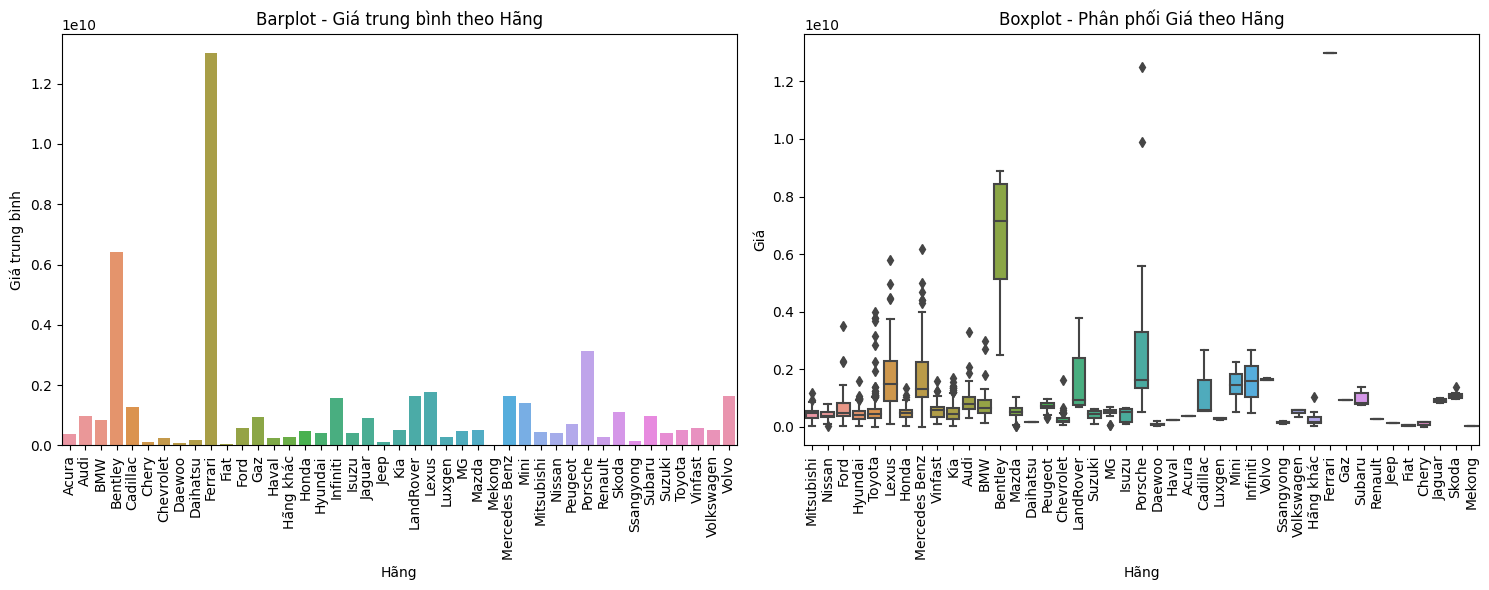

In [306]:
plot_bar_and_box(df, "Hãng", target_col)